# Data Science Case: Employee Attrition

The following is a fictional case study designed to loosely resemble the work you might undertake as part of Braskem’s Digital Center’s team. It will test your ability to handle data and perform statistical/machine learning analyses as well as your ability to communicate your findings and derive business insight from your technical work.
<br>
You may perform the analyses using any computational language you wish. Please submit your code along with your presentation and the requested results file at least 24h before the agreed date for your presentation.
<br>
Compose your findings in a PowerPoint or “Power-point like” presentation. You shall present these results during your technical test.

## Scenario
You are part of the Data Science group of a Digital Center in a fictitious company. The latest initiative prioritized by the portfolio team is “Employee attrition prediction & management” and you have been staffed as part of the squad in charge of the initiative. 
<br>
The project team has agreed on initiating the work by creating a MVP for one of the departments of the organization, before rolling-out the initiative to the rest of the company.


## Your task

We have scheduled a meeting in one week's time with the Leader of the People & Organization
department who is sponsoring the project. In this meeting, you will present: **1) your proposed DS approach for the initiative**, **2) the findings of the first week** (including at least one predictive model as prototype) and **3) the suggested next steps**
<br>
More specifically, you are in charge of building a model to predict which employees will leave the company. Also, you are responsible for suggesting how the company could leverage the termination data to reduce unwanted attrition.
<br>
The first stage is to establish the viability of such a model. For training your model you are provided with a dataset which includes features of Employees of a specific group within the company for each year over a 9-year period as well as their employment status for each of these years. 
<br>
Of particular interest for the audience attending the meeting, is how you frame the problem for training. Given that this is the first time the organization is resorting to predictive modelling, it is beneficial to leverage descriptive statistics and visualization for extracting interesting insights from the provided data before diving into the model. Also while it is not mandatory, you are encouraged to test multiple algorithms. If you do so it will helpful to describe the tested algorithms in a simple manner.
<br>
Using the trained model you shall “score” the data-points in the evaluation data set (provided in the eval_set.csv file). We ask that you please submit this file with your code and presentation.

## About the data

The dataset used in this technical test was obtained at a public repository. It represent fictitious data on employee terminations for a fictitious company.
<br>
For each of 9 years it show employees that are active and those that were termbrinated.
<br>
The datasets contain: employee id; employee record date ( year of data); birth date; hire date; termination date; age; length of service; city; department; job title; store number; gender; termination reason; termination type; status year; status; business unit
<br>
The evaluation dataset presents data for 2015 and doesn’t contain: termination date; termination reason; termination type; status

## Importing the data

The data is available in my Google Drive (Google colab has integration tools with Gdrive)

In [192]:
# Mont a Google drive, it bridges the your Gdrive with the colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [193]:
# Import libraries
from __future__ import print_function
import sys, os
import tempfile, urllib, zipfile
import warnings

# Ommit warnings
warnings.filterwarnings('ignore')

# Confirm it is using Python 2 due TFDV just works on python 2
assert sys.version_info.major is 2, 'Oops, not running Python 2'

# Set up some globals for our file paths
DATA_DIR = tempfile.mkdtemp()
OUTPUT_DIR = '/content/gdrive/My Drive/Export_Colab/'

# Download the zip file from Gdrive and unzip it
zip = '/content/gdrive/My Drive/Datasets/Technical Case - data sets.zip'
zipfile.ZipFile(zip).extractall(DATA_DIR)
zipfile.ZipFile(zip).close()

print("Here's what we downloaded:")
!ls -lR {DATA_DIR}

Here's what we downloaded:
/tmp/tmpulJd12:
total 8528
-rw-r--r-- 1 root root 8095814 Feb 25 02:02 data_employees.csv
-rw-r--r-- 1 root root  632757 Feb 25 02:02 eval_set.csv


### Data Validation

For the first analysis of the data, it will be use the Tensorflow Data Validation.

TensorFlow Data Validation (TFDV) is a library for exploring and validating machine learning data. It is designed to be highly scalable and to work well with TensorFlow and TensorFlow Extended (TFX)

Tensorflow Data Validation (TFDV) can analyze training and serving data to:

- compute descriptive statistics,

- infer a schema,

- detect data anomalies.

The TFDV is not available on the default packages in Google Colab, we install it  using pip

In [194]:
!pip install -q tensorflow_data_validation
import tensorflow_data_validation as tfdv

print('TFDV version: {}'.format(tfdv.version.__version__))

TFDV version: 0.12.0


### Compute and visualize statistics

TFDV can compute descriptive statistics providing a quick overview of the data in terms of the features, shapes and distribution of the values.

First use tfdv.generate_statistics_from_csv to compute statistics for train data, TFDV can compute descriptive statistics, generate_statistics_from_csv works specifying a file pattern. The pattern can contain glob characters  (*, ?, [...] and sets).

In [195]:
# Generate stats for Ste
train_stats = tfdv.generate_statistics_from_csv(
    data_location=os.path.join(DATA_DIR, 'data_employees.csv'))

# Visualize
tfdv.visualize_statistics(train_stats)

it is possible to check the distribution of each variable, categorical and numeric features are show separated,
<br>
The first thing it is possible to note the TERMINATED samples are very few compared with the ACTIVE, the class is very unbalanced
<br>
No missing data was found

### Evaluation Data

After check the training data, it will be compared with the test data,  if the data is different between the test and train data it will have problems when using the model for prediction.

In [196]:
# Compute stats for evaluation data
test_stats = tfdv.generate_statistics_from_csv(
    data_location=os.path.join(DATA_DIR, 'eval_set.csv'))

# Compare evaluation data with training data
tfdv.visualize_statistics(lhs_statistics=train_stats, 
                          rhs_statistics=test_stats,
                          lhs_name='Train_Dataset', 
                          rhs_name='Test_Dataset')

All the plots are between training and test data are show overlaid, it easy to check any value outside the distribution, looking at each plot it's possible to note there is no anomalies between the data.

## Exploration

Before get in the model, let's explore the data for insights

In [0]:
# Load libraries
import pandas as pd

# Read data
train = pd.read_csv(os.path.join(DATA_DIR, 'data_employees.csv'))
eval = pd.read_csv(os.path.join(DATA_DIR, 'eval_set.csv'))

### Employee Termination Rate by Year

The plot below shows the rate of employees terminated during the years

In [0]:
# Convert to datetime column
train['recorddate_key'] = pd.to_datetime(train['recorddate_key'])

# Group data by year
year = train.groupby(['STATUS', 
                      pd.Grouper(key='recorddate_key', 
                                 freq='Y')]).count().reset_index()

# Create a pivot table with the table
year = year.pivot(index='recorddate_key', 
                  columns='STATUS', 
                  values='EmployeeID').reset_index()

# Calculate the percentage
year['Active_perc'] = 100* year['ACTIVE'] / (year['ACTIVE']
                                             + year['TERMINATED'])

year['Terminated_perc'] = 100 * year['TERMINATED'] / (year['ACTIVE'] 
                                                      + year['TERMINATED'])

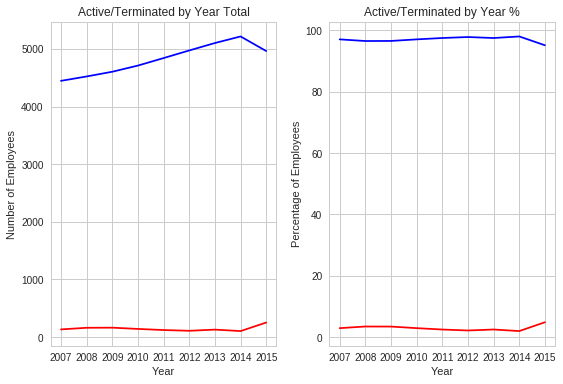

In [199]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.subplot(1, 2, 1)

plt.plot(year['recorddate_key'], year['ACTIVE'], color='blue')
plt.plot(year['recorddate_key'], year['TERMINATED'], color='red')

plt.xlabel('Year')
plt.ylabel('Number of Employees')

plt.title('Active/Terminated by Year Total')

plt.subplot(1, 2, 2)

plt.plot(year['recorddate_key'], year['Active_perc'], color='blue')
plt.plot(year['recorddate_key'], year['Terminated_perc'], color='red')

plt.xlabel('Year')
plt.ylabel('Percentage of Employees')


plt.title('Active/Terminated by Year %')

plt.tight_layout()
plt.show()

It is possible to conclude the years don't have any interference in the employee termination, there no specific year causes an incrise of the termination, the volume seems constantly over the years with small increase in the 2015

### Termination by Reason

Let's dive deep and investigate other variables, the next plot shows the termination split by reaso.

In [0]:
# Filter the data
data = train.loc[train['STATUS'] == 'TERMINATED']

# Groupby Termination Reason
reason = data.groupby('termreason_desc', as_index=False).count()

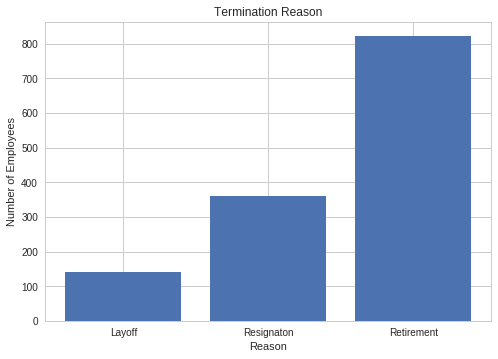

In [201]:
plt.bar(reason['termreason_desc'], reason['EmployeeID'])

plt.xlabel('Reason')
plt.ylabel('Number of Employees')

plt.title('Termination Reason')

plt.show()

It is possible to note most terminated employees are due **retirement**, for this case the solution it should be a replacement of the employee according to its age, termination by retirement it is not a attrition, layoff and resignation are reason we should work to mittigate, for the next plot we'll filter the data removing the retirement and take a closer look a the others reasons

### Termination by Department Unit

The plot shows the termination of the employee according each department.

In [0]:
# Filter the data
data = train.loc[(train['STATUS'] == 'TERMINATED') & 
                 (train['termreason_desc'] != 'Retirement')]

# Groupby Termination Department
depart = data.groupby('department_name', as_index=False).count()

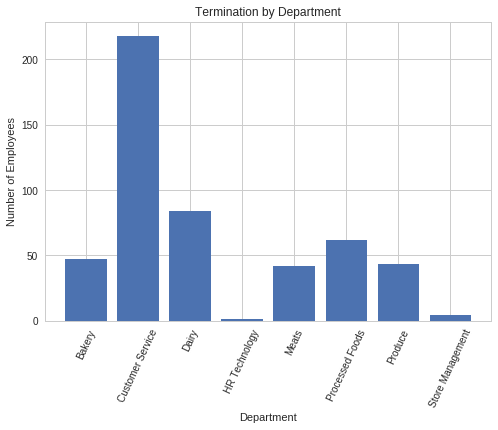

In [203]:
plt.bar(depart['department_name'], depart['EmployeeID'])

plt.xlabel('Department')
plt.xticks(rotation=65)
plt.ylabel('Number of Employees')

plt.title('Termination by Department')

plt.show()

The department of Customer Service has the highest number of termination almost four times the number of the others departments

### Termination by Title

The plot shows the distribuition of termination according each role

In [0]:
# Groupby Termination by Title
func = data.groupby('job_title', as_index=False).count()

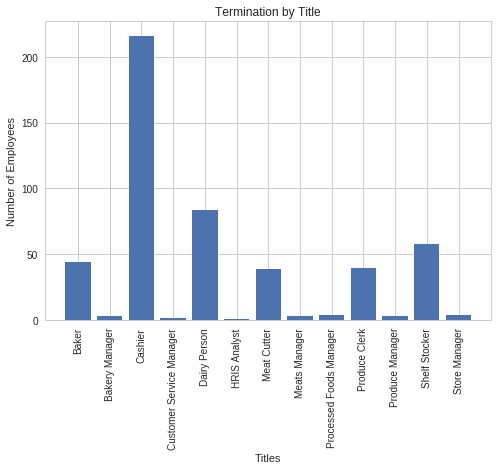

In [205]:
plt.bar(func['job_title'], func['EmployeeID'])

plt.xlabel('Titles')
plt.xticks(rotation=90)
plt.ylabel('Number of Employees')

plt.title('Termination by Title')

plt.show()

In [206]:
# Aggregate the data by department and title
depart_func = data.groupby(['department_name', 'job_title']).agg({'EmployeeID': 'count'})

# Distribuition of the termination according the title in the deparment
depart_func = depart_func.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

print(depart_func)

     department_name                 job_title  EmployeeID
0             Bakery                     Baker   93.617021
1             Bakery            Bakery Manager    6.382979
2   Customer Service                   Cashier   99.082569
3   Customer Service  Customer Service Manager    0.917431
4              Dairy              Dairy Person  100.000000
5      HR Technology              HRIS Analyst  100.000000
6              Meats               Meat Cutter   92.857143
7              Meats             Meats Manager    7.142857
8    Processed Foods   Processed Foods Manager    6.451613
9    Processed Foods             Shelf Stocker   93.548387
10           Produce             Produce Clerk   93.023256
11           Produce           Produce Manager    6.976744
12  Store Management             Store Manager  100.000000


In the department plot we noticed there are 6 departments with the hightest number of termination, looking at the first plot of the titles it shows somes roles has almost all the termination numbers of each department, so we made a third plot with the percentage of each termination to each function and we figured it out they correspond to more than 93% of the termination to each department.

### Correlation between Titles

At the specific titles, we'll filter the data and look for patterns can be common and can help us to plan actions for mitigated employee termination.

In [0]:
# List with the Titles
titles = ['Baker', 'Cashier', 'Dairy Person', 'Meat Cutter', 'Produce Clerk', 
          'Shelf Stocker']

# Filter the data
data = train.loc[(train['STATUS'] == 'TERMINATED') & 
                 (train['termreason_desc'] != 'Retirement') &
                 (train['job_title'].isin(titles))]

#### Termination Type

Tha variable termreason_desc is composed by two values Layoff and Resignaton, the Resignaton values means the employee has requested to leave the company, the Layoff means the Company has terminated the contract.

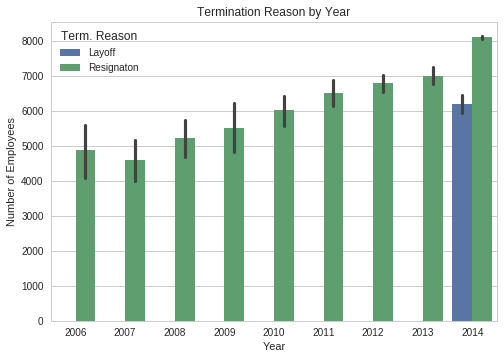

In [208]:
ax = sns.barplot(x="STATUS_YEAR", 
                 y="EmployeeID", 
                 hue='termreason_desc', 
                 data=data)

plt.legend(title='Term. Reason')
plt.xlabel('Year')
plt.ylabel('Number of Employees')
plt.title('Termination Reason by Year')

plt.show()

Looking at the plot there is just one year with layoff, probably due some event in 2014, when we model the data for the prediction using 2015 year we don't expected any Termination Reason by Layoff.

#### Termination Counts

The last plot will show termination counts by each employee age and with the level of lenght of service

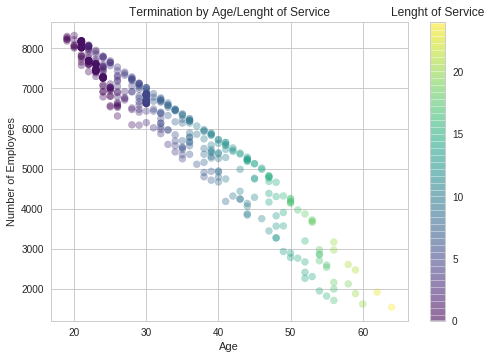

In [209]:
plt.scatter(x=data['age'], 
            y=data['EmployeeID'], 
            c=data['length_of_service'],
            cmap='viridis',
            alpha=0.35)

plt.xlabel('Age')
plt.ylabel('Number of Employees')
plt.colorbar().ax.set_title('Lenght of Service')
plt.title('Termination by Age/Lenght of Service')

plt.show()

The plot shows the most of terminations occur when the employee is younger and have few time of service, it could the first job and when the employee found other job more interesting he leaves the company. A solution for this problem could be a carrer plan for retention of the employee, also it could offer a job rotation, so instead the employee leaves the company he could try other roles.

### Conclusion

With this information we have an idea what to expect from our model, it should predict as terminated employees with several years of service and advanced age, those employees are expect the retirement, young employees with few years of service and age are also more prone to leave the company by resignation.

## Model

A machine learning model can be a mathematical representation of a real-world process.

### Preprocessing

Before get deep in the model first we have preprocess the data (scaling, dummy variables and so on)

- Extracted the year of the datetime columns
- Convert to numeric integer columns
- Get dummie columns for object columns
- Target variable will be encoded with 0 and 1

In [0]:
# Col types
dat_col = ['birthdate_key', 'orighiredate_key']
str_col = ['city_name', 'department_name', 'job_title', 'gender_full', 
           'BUSINESS_UNIT']
num_col = ['age', 'length_of_service', 'store_name', 'STATUS_YEAR']

In [0]:
# Import libraries
import itertools
import numpy as np

# Function to handle datetime columns
def year(dataframe, dat_col):
    dataframe = dataframe[dat_col].apply(pd.to_datetime)
    for col in dat_col:
        dataframe[col] = dataframe[col].apply(lambda row: row.year)

    return dataframe

# Function to handle numeric columns
def number(dataframe, num_col):
    dataframe = dataframe[num_col].apply(pd.to_numeric)
    
    return dataframe

# Function for string columns
def dummy(dataframe, str_col):
    dataframe = pd.get_dummies(dataframe[str_col])
    
    return dataframe

# Function to join the datasets
def join_cols(dataframe, dat_col, num_col, str_col):
    
    dat_dat = year(train, dat_col)
    num_dat = number(train, num_col)
    str_dat = dummy(train, str_col)
     
    dataframe = pd.concat([dat_dat, num_dat, str_dat], axis=1)
    
    return dataframe

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [0]:
# Read data
train = pd.read_csv(os.path.join(DATA_DIR, 'data_employees.csv'))
eval = pd.read_csv(os.path.join(DATA_DIR, 'eval_set.csv'))

# Import Libraries
from sklearn.preprocessing import LabelEncoder

# Feature data
X = join_cols(train, dat_col, num_col, str_col)

# Encoded target data
y = LabelEncoder().fit_transform(train['STATUS'])

### Decision Tree Classifier

Classification Tree learns a sequence of if-else questions about the features in order to infer the labels, the Tree is able to capture non-linearity relationships betweeen features and labels, as a plus Tree doens't require the features to be scaling before training.

Test set accuracy: 98.9036
Confusion matrix, without normalization
[[12940    71]
 [   76   321]]


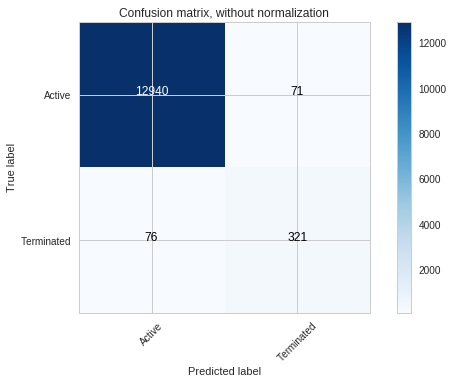

In [213]:
# Import libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Define Seed
SEED = 1

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=SEED,
                                                    stratify=y)

# Instantiate the classifier
dt = DecisionTreeClassifier(random_state=SEED)

# Fit the classifier to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred = dt.predict(X_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.4f}".format(acc * 100))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Define the class names for plot
class_names = ['Active', 'Terminated']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot the confusion matrix non-normalized
plt.show()

Normalized confusion matrix
[[0.99 0.01]
 [0.19 0.81]]


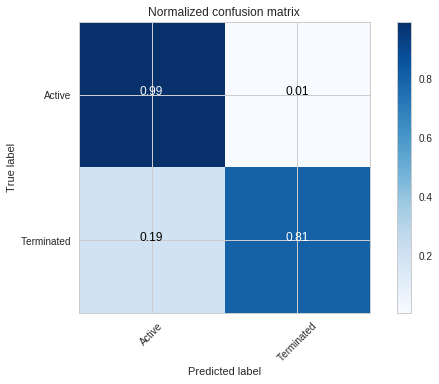

In [214]:
# Plot the confusion matrix normalized
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### LogisticRegression

Logistic regression is an algorithm used for supervised learning problems with binary classification, either 0 or 1, given a input x you want y hat that is the probability of y equals 1 given x.

Test set accuracy: 98.0385
Confusion matrix, without normalization
[[13011     0]
 [  263   134]]


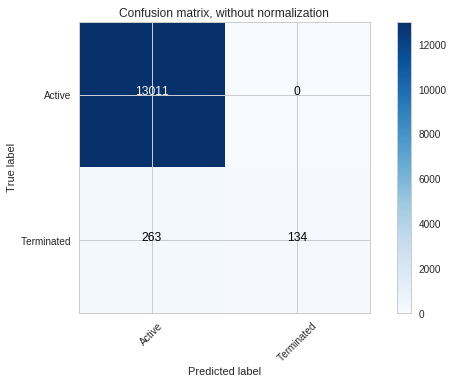

In [215]:
# Import libraries
from sklearn.linear_model import LogisticRegression

# Define Seed
SEED = 1

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=SEED,
                                                    stratify=y)

# Instantiate the classifier
lr = LogisticRegression(random_state=SEED)

# Fit the classifier to the training set
lr.fit(X_train, y_train)

# Predict test set labels
y_pred = lr.predict(X_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.4f}".format(acc * 100))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Define the class names for plot
class_names = ['Active', 'Terminated']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot the confusion matrix non-normalized
plt.show()

Normalized confusion matrix
[[1.   0.  ]
 [0.66 0.34]]


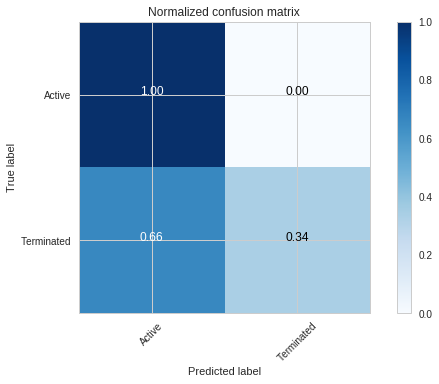

In [216]:
# Plot the confusion matrix normalized
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### KNeighborsClassifier

K nearest neighbors is an algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions)

Test set accuracy: 97.9863
Confusion matrix, without normalization
[[12990    21]
 [  249   148]]


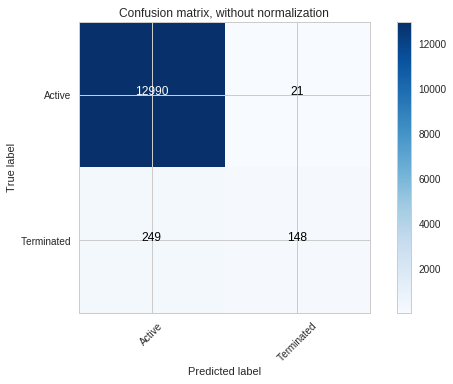

In [217]:
# Import libraries
from sklearn.neighbors import KNeighborsClassifier

# Define Seed
SEED = 1

# Split the data into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=SEED,
                                                    stratify=y)

# Instantiate the classifier
knn = KNeighborsClassifier(n_neighbors=2)

# Fit the classifier to the training set
knn.fit(X_train, y_train)

# Predict test set labels
y_pred = knn.predict(X_test)

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.4f}".format(acc * 100))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Define the class names for plot
class_names = ['Active', 'Terminated']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot the confusion matrix non-normalized
plt.show()

Normalized confusion matrix
[[1.   0.  ]
 [0.63 0.37]]


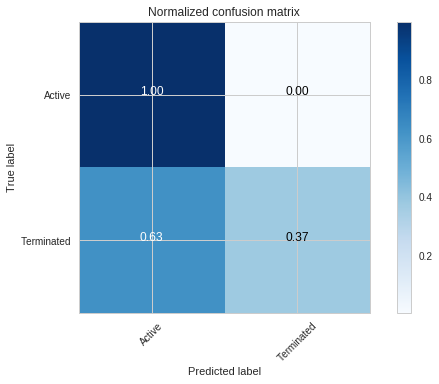

In [218]:
# Plot the confusion matrix normalized
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Prediction of Evaluation Data

In [219]:
# Feature data
X_eval = join_cols(eval, dat_col, num_col, str_col)

# Predict test set labels
eval_pred = dt.predict(X_eval)

# Print of the predict values
print(eval_pred)

[0 0 0 ... 0 0 1]


In [0]:
# Define path to save the predictions
file_path = os.path.join(OUTPUT_DIR, 'predictions.txt')

# Save predictions
np.savetxt(file_path, eval_pred, delimiter=',')

## Conclusion

The results seem very closed Classification Tree 98.9036, Logistic Regression 98.0385 and KNN 97.9863, the difference on the worst result to the best result is less than 1%, but we're dealing with an unbalanced class most of the data is composed by active employee, if we build an algorithm classifies all the employess as active it will has the accuracy of 97.04%, so the real result are show in the confusion matrix, the Classification Tree has the false positive of 19% against 66% of the Logistic Regression and 63% of KNN, so Classification Tree has performed better than the other algorithms.


## Next Steps

For improvement of the model we can test some procedures according to the algorithm choose.

**Classification Tree**

- Hyperparameters Tuning using Grid Search, Random Search, Genetic Algorithms...
- Feature Selection
- Cross validation
- Select Ensemble Tree models as Bagging or Random Forest

**Logistic Regression**

- Hyperparameters Tuning using Grid Search, Random Search, Genetic Algorithms...
- Regularization (Rigde or Lasso)
- Choose other linear algorithm (SVM)
- Preprocessing data (scaling, center)

**KNN**

- Preprocessing data (scaling, center)
- Choose another method to calculate the distance
- Use PCA to dimensioning reduction and plot and analyse how the data is classified